In [1]:
import imp
import torch
import torchvision
import torchvision.transforms as transforms
import models, modules, layers
from utils import lattice

In [2]:
imp.reload(models)

<module 'models' from '/home/bowenjo/Documents/GitHub/rf_pooling/rf_pool/models.py'>

In [3]:
# model params
loss_type = 'cross_entropy'
optimizer_type = 'sgd'
model = models.FeedForwardModel(loss_type, optimizer_type)

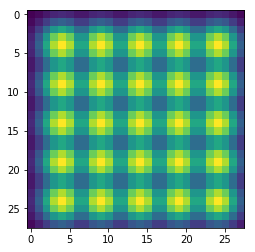

In [4]:
# rf layer
mu, sigma = lattice.init_uniform_lattice((14,14), 5, 5, sigma_init=2.)
kernels = lattice.gaussian_kernel_lattice(mu, sigma, (28,28))
rf_layer = layers.RF_Pool(mu, sigma, img_shape=(28,28), pool_type='sum')
rf_layer.init_rfs()
rf_layer.show_rfs()

In [5]:
# ff parameters
data_shape = (1,3,32,32)
layer_types = ['conv', 'conv', 'fc', 'fc', 'fc']
output_channels = [6, 16, 120, 84, 10]
kernel_sizes = [5]
act_types = ['relu']*4 + [None]
pool_types = ['max_pool', 'max_pool', None]
pool_ksizes = [2]
dropout_types = [None]

model.ff_network(data_shape, layer_types, act_types=act_types, 
                 pool_types=pool_types,
                 dropout_types=dropout_types,
                 output_channels=output_channels, 
                 kernel_sizes=kernel_sizes,
                 pool_ksizes=pool_ksizes)

n_params = len(model.get_trainable_params())
print("Number of 'on' params from ff_net: ", n_params)

Number of 'on' params from ff_net:  10


In [ ]:
# control parameters
control_layer_ids = [0]
control_layer_types = ['conv','fc']
branch_output_shapes = [(-1, 1, )]
control_output_channels = [16,256]
control_kernel_sizes = [5]
model.control_network(control_layer_ids, control_layer_types, branch_output_shapes,
                      output_channels=control_output_channels, kernel_sizes=control_kernel_sizes)

n_params = len(model.get_trainable_params())
print("Number of 'on' params from ff_net + control_net: ", n_params)

In [ ]:
# setting requires_gradient:
model.set_requires_grad("control", False) # turns off ff_net hidden layer params
n_params = len(model.get_trainable_params())
print("Number of 'on' params after removing contorl_net: ", n_params)

In [ ]:
# test random data
random_input = torch.rand(data_shape)
model(random_input).shape

In [6]:
# get CIFAR-10 training data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# train
epochs = 2
model.train_model(epochs, trainloader, monitor=2000, lr=.001, momentum=.9)

'[1, 11999] loss: 1.308'

In [9]:
# test accuracy
model.get_accuracy(testloader)

54.59